In [ ]:
# Colab cell A0 — mount Drive and create folders
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os
BASE = '/content/drive/MyDrive/airport_lighting_project'
DATA_DIR = os.path.join(BASE, 'data')
MODEL_DIR = os.path.join(BASE, 'models')
REPORTS_DIR = os.path.join(BASE, 'reports')
for d in [BASE, DATA_DIR, MODEL_DIR, REPORTS_DIR]:
    os.makedirs(d, exist_ok=True)
print("Project root created at:", BASE)


Mounted at /content/drive
Project root created at: /content/drive/MyDrive/airport_lighting_project


In [ ]:
# Colab cell A1 — minimal packages
!pip install -q numpy pandas scikit-learn matplotlib joblib


NEW realistic pre-optimization dataset (with area + lamp density)

In [ ]:
# REALISTIC AIRPORT LIGHTING DATASET (PRE-OPTIMIZATION) — UPDATED

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os, math

np.random.seed(42)

BASE = "/content/drive/MyDrive/airport_lighting_project"
DATA_DIR = os.path.join(BASE, "data")
os.makedirs(DATA_DIR, exist_ok=True)

# --- Airport zone configs (realistic) ---
# NOTE: checkin → checkin+arrival, areas updated to your values.
zones = {
    "checkin+arrival": {
        "target": 500,
        "max_art_lux": 700,
        "lamp_W": 60,         # per-lamp power (you can adjust)
        "area": 4206,         # m² (your value)
        "window": 0.7,
        "base_occ": 15
    },
    "security": {
        "target": 600,
        "max_art_lux": 800,
        "lamp_W": 80,
        "area": 2036,         # your value
        "window": 0.4,
        "base_occ": 20
    },
    "lounge": {
        "target": 350,
        "max_art_lux": 600,
        "lamp_W": 50,
        "area": 251,          # your value
        "window": 0.6,
        "base_occ": 10
    },
    "gate": {
        "target": 350,
        "max_art_lux": 600,
        "lamp_W": 50,
        "area": 15,           # your value
        "window": 0.5,
        "base_occ": 12
    }
}

# Global lamp density (same for all zones, but you can customize per-zone)
LAMP_DENSITY = 1.0 / 10.0   # 1 lamp per 10 m²

start = datetime(2025, 1, 1)
interval_min = 10
days = 30
rows = []

# --- Solar curve model ---
def solar_lux(m):
    theta = 2*np.pi*(m/1440)
    peak = 20000
    base = peak * max(0, np.sin(theta))
    cloud = np.random.normal(1.0, 0.10)
    return max(0, base * cloud)

# --- Occupancy model ---
def airport_occupancy(minute, base):
    # peak 6–10 am, 5–9 pm
    morning_peak = np.exp(-((minute-480)/180)**2)
    evening_peak = np.exp(-((minute-1140)/200)**2)
    noise = np.random.normal(0, 3)
    occ = base + 40*morning_peak + 35*evening_peak + noise
    return max(0, int(occ))

# --- Baseline dimming (inefficient) ---
def baseline_dim(daylight, target):
    if daylight >= target:
        return 0.0, "daylight_off"

    dim = float(min(1.0, max(0.6, np.random.normal(0.9, 0.12))))
    return dim, "bad_baseline"

for zname, cfg in zones.items():
    # pre-compute lamp-related parameters for the zone
    area = cfg["area"]
    lamp_W = cfg["lamp_W"]

    # number of lamps (ceil to ensure enough light)
    num_lamps = math.ceil(area * LAMP_DENSITY)

    # total installed power in that zone
    total_power_W = lamp_W * num_lamps

    for d in range(days):
        for step in range(144):  # 144 * 10 min = 24 hours
            t = start + timedelta(days=d, minutes=step*interval_min)
            tm = t.hour*60 + t.minute

            # DAYLIGHT
            daylight = cfg["window"] * solar_lux(tm)

            # OCCUPANCY
            occ = airport_occupancy(tm, cfg["base_occ"])

            # GLARE
            glare = np.clip((daylight-2500)/8000 + np.random.normal(0, 0.03), 0, 1)

            # TEMP
            temp = 20 + 5*np.sin(2*np.pi*(tm/1440)) + np.random.normal(0, 0.3)

            # BASELINE DIM
            dim, dim_src = baseline_dim(daylight, cfg["target"])

            # ARTIFICIAL LUX
            artificial = dim * cfg["max_art_lux"]

            # SENSOR LUX
            sensor = daylight + artificial + np.random.normal(0, 8)

            # NEW ENERGY MODEL (using total installed power)
            energy = (total_power_W * dim) * (interval_min/60) / 1000

            rows.append({
                "zone": zname,
                "timestamp": t.isoformat(),
                "time_min": tm,
                "area_m2": area,
                "daylight_lux": daylight,
                "occupancy": occ,
                "glare": glare,
                "temp_C": temp,
                "current_dim": dim,
                "dim_source": dim_src,
                "max_artificial_lux": cfg["max_art_lux"],
                "lamp_power_W": lamp_W,           # per-lamp rating
                "num_lamps": num_lamps,           # NEW
                "total_power_W": total_power_W,   # NEW
                "sensor_lux": sensor,
                "energy_kWh": energy,
                "target_lux": cfg["target"],
            })

df = pd.DataFrame(rows)

out = os.path.join(DATA_DIR, "data_preopt.csv")
df.to_csv(out, index=False)

print("Saved realistic synthetic dataset to:", out)
print("\nRows generated:", len(df))
print("\nEnergy summary (kWh) :")
print(df["energy_kWh"].describe())
print("\nPer-zone mean energy:")
print(df.groupby("zone")["energy_kWh"].mean())
df.sample(10)


Saved realistic synthetic dataset to: /content/drive/MyDrive/airport_lighting_project/data/data_preopt.csv

Rows generated: 17280

Energy summary (kWh) :
count    17280.000000
mean         0.815387
std          1.379615
min          0.000000
25%          0.000000
50%          0.012283
75%          1.924780
max          4.210000
Name: energy_kWh, dtype: float64

Per-zone mean energy:
zone
checkin+arrival    1.896844
gate               0.007499
lounge             0.097195
security           1.260011
Name: energy_kWh, dtype: float64


,zone,timestamp,time_min,area_m2,daylight_lux,occupancy,glare,temp_C,current_dim,dim_source,max_artificial_lux,lamp_power_W,num_lamps,total_power_W,sensor_lux,energy_kWh,target_lux
16989,gate,2025-01-28T23:30:00,1410,15,0.000000,15,0.000000,18.938875,0.897201,bad_baseline,600,50,2,100,522.751353,0.014953,350
13010,gate,2025-01-01T08:20:00,500,15,8464.726642,53,0.731322,23.760414,0.000000,daylight_off,600,50,2,100,8475.590347,0.000000,350
2829,checkin+arrival,2025-01-20T15:30:00,930,4206,0.000000,30,0.000000,15.987824,0.600000,bad_baseline,700,60,421,25260,419.054332,2.526000,500
10582,lounge,2025-01-14T11:40:00,700,251,1042.792871,23,0.000000,20.326551,0.000000,daylight_off,600,50,26,1300,1027.038595,0.000000,350
2410,checkin+arrival,2025-01-17T17:40:00,1060,4206,0.000000,50,0.000000,15.162880,0.964759,bad_baseline,700,60,421,25260,680.232012,4.061634,500
4347,security,2025-01-01T04:30:00,270,2036,7623.494509,30,0.653664,24.542982,0.000000,daylight_off,800,80,204,16320,7619.641249,0.000000,600
15956,gate,2025-01-21T19:20:00,1160,15,0.000000,47,0.000000,15.399828,1.000000,bad_baseline,600,50,2,100,590.862247,0.016667,350
12681,lounge,2025-01-29T01:30:00,90,251,4659.375105,8,0.263758,21.926361,0.000000,daylight_off,600,50,26,1300,4665.246079,0.000000,350
12315,lounge,2025-01-26T12:30:00,750,251,0.000000,13,0.000000,19.551512,1.000000,bad_baseline,600,50,26,1300,592.018891,0.216667,350
2516,checkin+arrival,2025-01-18T11:20:00,680,4206,2929.811719,30,0.088322,20.776234,0.000000,daylight_off,700,60,421,25260,2931.648864,0.000000,500


Random Forest on PRE-OPT data (with new features)

Loaded rows: 17280
Train rows: 13824 Test rows: 3456

===== PRE-OPT RF PERFORMANCE =====
Train R²: 1.0000
Test  R²: 0.9998
Train RMSE: 0.000521 kWh
Test  RMSE: 0.000096 kWh
Train MAE:  0.000129 kWh

Top feature importances:
current_dim           4.714841e-01
total_power_W         1.051886e-01
lamp_power_W          9.398866e-02
area_m2               9.285334e-02
max_artificial_lux    8.545234e-02
target_lux            8.099917e-02
num_lamps             7.002183e-02
time_min              1.184851e-05
daylight_lux          6.345706e-08
occupancy             1.027733e-08
temp_C                9.623923e-09
glare                 0.000000e+00
dtype: float64


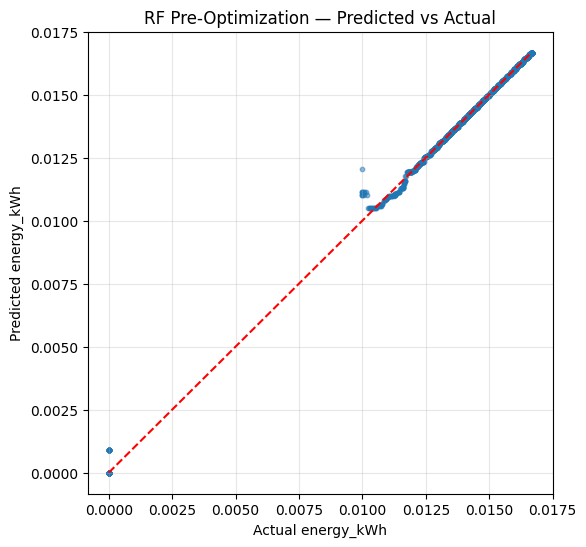

Saved RF model to: /content/drive/MyDrive/airport_lighting_project/models/rf_pre.pkl


In [ ]:
# === RF MODEL ON PRE-OPT DATA (NEW FEATURES) ===

import pandas as pd, numpy as np, joblib, os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/airport_lighting_project"
DATA = os.path.join(BASE, "data", "data_preopt.csv")
MODEL_DIR = os.path.join(BASE, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

df = pd.read_csv(DATA)
print("Loaded rows:", len(df))

# Include num_lamps and total_power_W now
feature_cols = [
    "area_m2", "time_min", "daylight_lux", "occupancy", "glare",
    "temp_C", "current_dim", "max_artificial_lux",
    "lamp_power_W", "num_lamps", "total_power_W", "target_lux"
]

X = df[feature_cols]
y = df["energy_kWh"]

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train rows:", len(X_train), "Test rows:", len(X_test))

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_tr_pred = rf.predict(X_train)
y_te_pred = rf.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_tr_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test,  y_te_pred))
mae_train  = mean_absolute_error(y_train, y_tr_pred)
mae_test   = mean_absolute_error(y_test,  y_te_pred)

print("\n===== PRE-OPT RF PERFORMANCE =====")
print(f"Train R²: {r2_score(y_train, y_tr_pred):.4f}")
print(f"Test  R²: {r2_score(y_test, y_te_pred):.4f}")
print(f"Train RMSE: {rmse_train:.6f} kWh")
print(f"Test  RMSE: {rmse_test:.6f} kWh")
print(f"Train MAE:  {mae_train:.6f} kWh")
print("\nTop feature importances:")
imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(imp.head(12))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_te_pred, s=10, alpha=0.5)
mx = max(y_test.max(), y_te_pred.max())
plt.plot([0,mx],[0,mx],'r--')
plt.xlabel("Actual energy_kWh")
plt.ylabel("Predicted energy_kWh")
plt.title("RF Pre-Optimization — Predicted vs Actual")
plt.grid(alpha=0.3)
plt.show()

OUT = os.path.join(MODEL_DIR, "rf_pre.pkl")
joblib.dump(rf, OUT)
print("Saved RF model to:", OUT)


3.Updated Lighting Environment + rule-based optimization






 3.1 Environment (now uses total_power_W)

In [ ]:
# STEP 3.1 — Lighting Simulator Environment (deterministic, NEW POWER MODEL)
import numpy as np

class LightingEnvSimple:
    def __init__(self, df_zone, interval_min=10):
        self.df = df_zone.reset_index(drop=True)
        self.interval_min = interval_min
        self.idx = 0
        self.n = len(self.df)

    def reset(self, start_idx=0):
        self.idx = start_idx
        row = self.df.loc[self.idx].to_dict()
        return self.row_to_state(row)

    def row_to_state(self, row):
        return {
            'daylight': float(row['daylight_lux']),
            'occupancy': float(row['occupancy']),
            'glare': float(row['glare']),
            'temp': float(row['temp_C']),
            'cur_dim': float(row['current_dim']),
            'max_art': float(row['max_artificial_lux']),
            'lamp_W': float(row['lamp_power_W']),
            'num_lamps': float(row['num_lamps']),
            'total_power_W': float(row['total_power_W']),
            'target': float(row['target_lux']),
            'area': float(row['area_m2'])
        }

    def step(self, action_dim):
        dim = float(np.clip(action_dim, 0.0, 1.0))
        row = self.df.loc[self.idx].to_dict()

        artificial = dim * row['max_artificial_lux']
        sensor_lux = float(row['daylight_lux'] + artificial)

        # NEW: energy uses total_power_W, not single lamp_W
        energy_kWh = float(
            (row['total_power_W'] * dim) * (self.interval_min/60.0) / 1000.0
        )

        comfort_err = float(abs(sensor_lux - row['target_lux']) / row['target_lux'])

        info = {
            'sensor_lux': sensor_lux,
            'dim_used': dim
        }

        self.idx += 1
        done = self.idx >= self.n
        if not done:
            next_state = self.row_to_state(self.df.loc[self.idx].to_dict())
        else:
            next_state = None

        return next_state, energy_kWh, comfort_err, done, info


3.2 Rule-based optimization & post-opt dataset

In [ ]:
# STEP 3.2 — Run rule-based optimization over all zones (NEW DATA)

import pandas as pd
import os

BASE = "/content/drive/MyDrive/airport_lighting_project"
pre_df = pd.read_csv(os.path.join(BASE, "data", "data_preopt.csv"))

zones = pre_df['zone'].unique()
post_rows = []

for zone in zones:
    df_zone = pre_df[pre_df['zone'] == zone].reset_index(drop=True)
    env = LightingEnvSimple(df_zone)
    env.reset()

    for i in range(len(df_zone)):
        row = df_zone.loc[i].to_dict()

        daylight = row['daylight_lux']
        occ = row['occupancy']
        target = row['target_lux']
        max_art = row['max_artificial_lux']

        # RULE-BASED LOGIC
        if daylight >= target:
            dim = 0.0
        elif occ == 0:
            dim = 0.05
        else:
            required = max(0, target - daylight)
            dim = required / max_art
            dim = float(np.clip(dim, 0.15, 0.85))

        next_state, energy_kWh, comfort_err, done, info = env.step(dim)

        post_rows.append({
            'zone': zone,
            'timestamp': row['timestamp'],
            'daylight_lux': daylight,
            'occupancy': occ,
            'glare': row['glare'],
            'temp_C': row['temp_C'],
            'dim_used': info['dim_used'],
            'sensor_lux': info['sensor_lux'],
            'energy_kWh': energy_kWh,
            'target_lux': target
        })

post_df = pd.DataFrame(post_rows)
out_path = os.path.join(BASE, "data", "data_postopt_rule.csv")
post_df.to_csv(out_path, index=False)

print("\nSaved post-opt dataset →", out_path)
print("Rows:", len(post_df))
print("\nEnergy summary (post-opt):")
print(post_df["energy_kWh"].describe())

# STEP 3.3 — energy savings (simulator)
pre = pd.read_csv(os.path.join(BASE,"data","data_preopt.csv"))
post = pd.read_csv(os.path.join(BASE,"data","data_postopt_rule.csv"))

E_pre  = pre['energy_kWh'].sum()
E_post = post['energy_kWh'].sum()
savings = (E_pre - E_post) / E_pre * 100 if E_pre != 0 else np.nan

print("===== ENERGY SAVINGS (RULE-BASED) =====")
print(f"Pre-opt total energy : {E_pre:.4f} kWh")
print(f"Post-opt total energy: {E_post:.4f} kWh")
print(f"Percent saved        : {savings:.2f}%")



Saved post-opt dataset → /content/drive/MyDrive/airport_lighting_project/data/data_postopt_rule.csv
Rows: 17280

Energy summary (post-opt):
count    17280.000000
mean         0.660143
std          1.114698
min          0.000000
25%          0.000000
50%          0.009722
75%          2.040000
max          3.007143
Name: energy_kWh, dtype: float64
===== ENERGY SAVINGS (RULE-BASED) =====
Pre-opt total energy : 14089.8904 kWh
Post-opt total energy: 11407.2723 kWh
Percent saved        : 19.04%


4. RF on POST-OPT data (with new meta columns)

In [ ]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

BASE = "/content/drive/MyDrive/airport_lighting_project"

# 1) Load pre- and post-optimized datasets
pre  = pd.read_csv(os.path.join(BASE, "data", "data_preopt.csv"))
post = pd.read_csv(os.path.join(BASE, "data", "data_postopt_rule.csv"))

# 2) Merge to bring area, time_min, power, etc. into post-opt dataset
merged = post.merge(
    pre[[
        "zone", "timestamp", "area_m2", "time_min",
        "max_artificial_lux", "lamp_power_W",
        "num_lamps", "total_power_W",
        "target_lux"
    ]],
    on=["zone", "timestamp"],
    how="left"
)

print("Merged post-opt rows:", len(merged))
print(merged.head())

# 3) Fix column names if duplicated
if "target_lux_x" in merged.columns:
    merged = merged.rename(columns={"target_lux_x": "target_lux"})
if "target_lux_y" in merged.columns:
    merged = merged.drop(columns=["target_lux_y"])

# 4) Define feature columns
feature_cols_post = [
    "area_m2",
    "time_min",
    "daylight_lux",
    "occupancy",
    "glare",
    "temp_C",
    "dim_used",
    "max_artificial_lux",
    "lamp_power_W",
    "num_lamps",
    "total_power_W",
    "target_lux"
]

# 5) Drop rows with missing values in features or target (defensive)
cols_needed = feature_cols_post + ["energy_kWh"]
before_drop = len(merged)
merged = merged.dropna(subset=cols_needed)
after_drop = len(merged)
print(f"Dropped {before_drop - after_drop} rows with NaNs in features/target.")

# 6) Shuffle the dataset BEFORE splitting
merged = merged.sample(frac=1.0, random_state=123).reset_index(drop=True)

# 7) Build X, y AFTER shuffling
X = merged[feature_cols_post]
y = merged["energy_kWh"]

# 8) Train-test split (same style as before, but on shuffled data)
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train rows:", len(X_train), "Test rows:", len(X_test))

# 9) Train RF (same hyperparameters)
rf_post = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=20,
    n_jobs=-1,
    random_state=123
)
rf_post.fit(X_train, y_train)

# 10) Evaluate
yp_train = rf_post.predict(X_train)
yp_test  = rf_post.predict(X_test)

print("\n===== POST-OPT RF PERFORMANCE =====")
print("Train R²:", r2_score(y_train, yp_train))
print("Test  R²:", r2_score(y_test, yp_test))
print("Train RMSE:", mean_squared_error(y_train, yp_train) ** 0.5, "kWh")
print("Test  RMSE:", mean_squared_error(y_test, yp_test) ** 0.5, "kWh")
print("Train MAE:", mean_absolute_error(y_train, yp_train), "kWh")
print("Test  MAE:", mean_absolute_error(y_test, yp_test), "kWh")

# 11) Save model
os.makedirs(os.path.join(BASE, "models"), exist_ok=True)
joblib.dump(rf_post, os.path.join(BASE, "models", "rf_post.pkl"))
print("\nSaved post-opt RF model to models/rf_post.pkl")


Merged post-opt rows: 17280
              zone            timestamp  daylight_lux  occupancy  glare  \
0  checkin+arrival  2025-01-01T00:00:00      0.000000         14    0.0   
1  checkin+arrival  2025-01-01T00:10:00    707.109437         17    0.0   
2  checkin+arrival  2025-01-01T00:20:00   1163.352967         15    0.0   
3  checkin+arrival  2025-01-01T00:30:00   1642.285306         16    0.0   
4  checkin+arrival  2025-01-01T00:40:00   2376.186587         15    0.0   

      temp_C  dim_used   sensor_lux  energy_kWh  target_lux_x  area_m2  \
0  20.456909  0.714286   500.000000    3.007143           500     4206   
1  20.380865  0.000000   707.109437    0.000000           500     4206   
2  19.918303  0.000000  1163.352967    0.000000           500     4206   
3  20.228940  0.000000  1642.285306    0.000000           500     4206   
4  20.704926  0.000000  2376.186587    0.000000           500     4206   

   time_min  max_artificial_lux  lamp_power_W  num_lamps  total_power_W  \
0

5. Final savings (simulator + RF-predicted) with new features

In [ ]:
# FINAL — Compare energy savings (simulator actual + RF predicted) — UPDATED

import os, pandas as pd, joblib, numpy as np

BASE = "/content/drive/MyDrive/airport_lighting_project"
pre_path  = os.path.join(BASE, "data", "data_preopt.csv")
post_path = os.path.join(BASE, "data", "data_postopt_rule.csv")
rf_pre_path  = os.path.join(BASE, "models", "rf_pre.pkl")
rf_post_path = os.path.join(BASE, "models", "rf_post.pkl")

pre  = pd.read_csv(pre_path)
post = pd.read_csv(post_path)

print("Rows pre:", len(pre), "Rows post:", len(post))
print("Pre columns:", pre.columns.tolist())
print("Post columns:", post.columns.tolist())

# 1) REAL simulator totals
E_pre  = pre["energy_kWh"].sum()
E_post = post["energy_kWh"].sum()
savings = (E_pre - E_post) / E_pre * 100 if E_pre != 0 else np.nan

print("\n===== REAL ENERGY SAVINGS (SIMULATOR) =====")
print(f"Pre-opt total energy : {E_pre:.6f} kWh")
print(f"Post-opt total energy: {E_post:.6f} kWh")
print(f"Percent saved        : {savings:.2f}%")

# 2) RF-predicted totals (optional)
if not (os.path.exists(rf_pre_path) and os.path.exists(rf_post_path)):
    print("\nRF models not found at expected locations. Skipping RF-predicted totals.")
else:
    rf_pre  = joblib.load(rf_pre_path)
    rf_post = joblib.load(rf_post_path)

    feat_pre = [
        "area_m2","time_min","daylight_lux","occupancy","glare","temp_C",
        "current_dim","max_artificial_lux",
        "lamp_power_W","num_lamps","total_power_W","target_lux"
    ]

    feat_post = [
        "area_m2","time_min","daylight_lux","occupancy","glare","temp_C",
        "dim_used","max_artificial_lux",
        "lamp_power_W","num_lamps","total_power_W","target_lux"
    ]

    meta_cols = [
        "zone","timestamp",
        "area_m2","time_min",
        "max_artificial_lux","lamp_power_W",
        "num_lamps","total_power_W",
        "target_lux","current_dim"
    ]

    pre_meta = pre[meta_cols].drop_duplicates(subset=["zone","timestamp"])

    post_full = post.merge(pre_meta, on=["zone","timestamp"], how="left", suffixes=("","_premeta"))

    if "target_lux" not in post_full.columns or post_full["target_lux"].isna().any():
        print("Warning: 'target_lux' missing after merge — filling from per-zone defaults if available.")
        zone_target_map = pre.groupby("zone")["target_lux"].agg(
            lambda s: s.dropna().mode().iloc[0] if not s.dropna().empty else np.nan
        ).to_dict()
        post_full["target_lux"] = post_full.apply(
            lambda r: r["target_lux"] if pd.notna(r.get("target_lux")) else zone_target_map.get(r["zone"], np.nan),
            axis=1
        )

    missing_pre  = [c for c in feat_pre  if c not in pre.columns]
    missing_post = [c for c in feat_post if c not in post_full.columns]
    if missing_pre:
        print("Cannot predict with rf_pre — missing features in pre:", missing_pre)
    if missing_post:
        print("Cannot predict with rf_post — missing features in post_full:", missing_post)

    if not missing_pre and not missing_post:
        X_pre  = pre[feat_pre].copy()
        X_post = post_full[feat_post].copy()

        pred_pre_total  = rf_pre.predict(X_pre).sum()
        pred_post_total = rf_post.predict(X_post).sum()
        pred_savings = (pred_pre_total - pred_post_total) / pred_pre_total * 100 if pred_pre_total != 0 else np.nan

        print("\n===== RF-PREDICTED SAVINGS =====")
        print(f"RF Pre-opt total : {pred_pre_total:.6f} kWh")
        print(f"RF Post-opt total: {pred_post_total:.6f} kWh")
        print(f"RF Savings       : {pred_savings:.2f}%")
    else:
        print("\nSkipping RF-prediction due to missing features. See messages above.")

# 3) Per-zone simulator savings
print("\n===== PER-ZONE REAL SAVINGS =====")
zone_pre  = pre.groupby("zone")["energy_kWh"].sum().sort_index()
zone_post = post.groupby("zone")["energy_kWh"].sum().sort_index()

for z in zone_pre.index:
    pre_val  = zone_pre.loc[z]
    post_val = zone_post.loc[z] if z in zone_post.index else 0.0
    sv = (pre_val - post_val) / pre_val * 100 if pre_val != 0 else np.nan
    print(f"Zone {z:15s} pre: {pre_val:.6f} kWh  post: {post_val:.6f} kWh  saved: {sv:.2f}%")

print("\nDone.")


Rows pre: 17280 Rows post: 17280
Pre columns: ['zone', 'timestamp', 'time_min', 'area_m2', 'daylight_lux', 'occupancy', 'glare', 'temp_C', 'current_dim', 'dim_source', 'max_artificial_lux', 'lamp_power_W', 'num_lamps', 'total_power_W', 'sensor_lux', 'energy_kWh', 'target_lux']
Post columns: ['zone', 'timestamp', 'daylight_lux', 'occupancy', 'glare', 'temp_C', 'dim_used', 'sensor_lux', 'energy_kWh', 'target_lux']

===== REAL ENERGY SAVINGS (SIMULATOR) =====
Pre-opt total energy : 14089.890395 kWh
Post-opt total energy: 11407.272288 kWh
Percent saved        : 19.04%

===== RF-PREDICTED SAVINGS =====
RF Pre-opt total : 14089.817960 kWh
RF Post-opt total: 11407.297290 kWh
RF Savings       : 19.04%

===== PER-ZONE REAL SAVINGS =====
Zone checkin+arrival pre: 8194.367235 kWh  post: 6587.537357 kWh  saved: 19.61%
Zone gate            pre: 32.395442 kWh  post: 21.299167 kWh  saved: 34.25%
Zone lounge          pre: 419.882020 kWh  post: 276.791667 kWh  saved: 34.08%
Zone security        pre: 54